In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/emotion_input_output

/content/drive/My Drive/emotion_input_output


In [ ]:
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split

import os
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten,BatchNormalization
from tensorflow.keras.layers import Dense, MaxPooling2D,Conv2D
from tensorflow.keras.layers import Input,Activation,Add
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

import pandas as pd

from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPool2D,Dense,Dropout,BatchNormalization,Flatten,Input
from sklearn.model_selection import train_test_split

# Import dataset

In [ ]:
dataset_folder='./input/CK+48'
sub_folders=os.listdir(dataset_folder)

sub_folders

['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise']

In [ ]:
# Reading folder names as labels and images underneath
i=0
last=[]
images=[]
labels=[]
temp = sub_folders

# reading folders in the main dataset folder, one at a time
for sub_folder in sub_folders:
  sub_folder_index = temp.index(sub_folder)
  label = sub_folder_index

  # Define labels basis use case. We are using positive:0, negative:1, neutral:2 
  # for our use case of predicting emotions of visitors entering a retail store
  if  label in [4, 6]:    # label in ['happy', 'surprise']
    new_label=0           # changed to label = positive emotion
  elif label in [0,5]:      # label in ['anger','sadness']
    new_label=1           # changed to label = negative emotion
  else:                   # label in ['contempt', 'disgust', 'fear']
    new_label=2           # changed to label = neutral emotion
  
  
  path = dataset_folder+'/'+sub_folder
  sub_folder_images= os.listdir(path)
  
  # reading images in the sub folder, one at a time
  for image in sub_folder_images:
    image_path = path+'/'+image
    print(image_path+"\t"+str(new_label))
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image= cv2.resize(image,(48,48))
    images.append(image)
    labels.append(new_label)
    i+=1
  last.append(i)

./input/CK+48/anger/S034_003_00000025.png	1
./input/CK+48/anger/S029_001_00000017.png	1
./input/CK+48/anger/S028_001_00000022.png	1
./input/CK+48/anger/S029_001_00000019.png	1
./input/CK+48/anger/S032_003_00000017.png	1
./input/CK+48/anger/S032_003_00000016.png	1
./input/CK+48/anger/S028_001_00000024.png	1
./input/CK+48/anger/S028_001_00000023.png	1
./input/CK+48/anger/S032_003_00000015.png	1
./input/CK+48/anger/S029_001_00000018.png	1
./input/CK+48/anger/S026_003_00000015.png	1
./input/CK+48/anger/S026_003_00000014.png	1
./input/CK+48/anger/S014_003_00000029.png	1
./input/CK+48/anger/S014_003_00000030.png	1
./input/CK+48/anger/S022_005_00000032.png	1
./input/CK+48/anger/S022_005_00000030.png	1
./input/CK+48/anger/S014_003_00000028.png	1
./input/CK+48/anger/S026_003_00000013.png	1
./input/CK+48/anger/S011_004_00000021.png	1
./input/CK+48/anger/S022_005_00000031.png	1
./input/CK+48/anger/S011_004_00000020.png	1
./input/CK+48/anger/S011_004_00000019.png	1
./input/CK+48/anger/S010_004_000

In [ ]:
images_x = np.array(images)
labels_y = np.array(labels)

# we divide image pixels by 255 to reduce computation power
images_x = images_x/255

In [ ]:
images_x.shape

(991, 48, 48)

In [ ]:
# encoding the labels
num_of_classes = 3
labels_y_encoded = tf.keras.utils.to_categorical(labels_y,num_classes=num_of_classes)

# Split into Train / Test

In [ ]:
X_train, X_test, Y_train, Y_test= train_test_split(images_x, labels_y_encoded,test_size=0.25, random_state=10)

In [ ]:
len(X_train)

743

In [ ]:
len(X_test)

248

#Define CNN Architecture

In [ ]:
input = Input(shape = (48,48,1))

conv1 = Conv2D(32,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(input)
conv1 = Dropout(0.1)(conv1)
conv1 = Activation('relu')(conv1)
pool1 = MaxPooling2D(pool_size = (2,2)) (conv1)

conv2 = Conv2D(64,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool1)
conv2 = Dropout(0.1)(conv2)
conv2 = Activation('relu')(conv2)
pool2 = MaxPooling2D(pool_size = (2,2)) (conv2)

conv3 = Conv2D(128,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool2)
conv3 = Dropout(0.1)(conv3)
conv3 = Activation('relu')(conv3)
pool3 = MaxPooling2D(pool_size = (2,2)) (conv3)

conv4 = Conv2D(256,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool3)
conv4 = Dropout(0.1)(conv4)
conv4 = Activation('relu')(conv4)
pool4 = MaxPooling2D(pool_size = (2,2)) (conv4)

flatten = Flatten()(pool4)

dense_1 = Dense(128,activation='relu')(flatten)

drop_1 = Dropout(0.2)(dense_1)

output = Dense(3,activation="sigmoid")(drop_1)

In [ ]:
model = Model(inputs=input,outputs=output)
model.compile(optimizer="adam", loss=["categorical_crossentropy"], metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 dropout (Dropout)           (None, 48, 48, 32)        0         
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                             

#Model Training

In [ ]:
fle_s='./output/emotion_model.h5'
checkpointer = ModelCheckpoint(fle_s, monitor='loss',verbose=1,save_best_only=True,
                               save_weights_only=False, mode='auto',save_freq='epoch')
callback_list=[checkpointer]

In [ ]:
save = model.fit(X_train,Y_train,batch_size=32,validation_data=(X_test,Y_test),epochs=50,callbacks=[callback_list])

Epoch 1/50
24/24 [==============================] - ETA: 0s - loss: 1.2814 - accuracy: 0.4590
Epoch 1: loss improved from inf to 1.28138, saving model to ./output/emotion_model.h5
24/24 [==============================] - 10s 371ms/step - loss: 1.2814 - accuracy: 0.4590 - val_loss: 1.1951 - val_accuracy: 0.4597
Epoch 2/50
24/24 [==============================] - ETA: 0s - loss: 1.1328 - accuracy: 0.4738
Epoch 2: loss improved from 1.28138 to 1.13277, saving model to ./output/emotion_model.h5
24/24 [==============================] - 7s 283ms/step - loss: 1.1328 - accuracy: 0.4738 - val_loss: 1.0567 - val_accuracy: 0.5081
Epoch 3/50
24/24 [==============================] - ETA: 0s - loss: 0.8956 - accuracy: 0.5949
Epoch 3: loss improved from 1.13277 to 0.89565, saving model to ./output/emotion_model.h5
24/24 [==============================] - 7s 281ms/step - loss: 0.8956 - accuracy: 0.5949 - val_loss: 0.7677 - val_accuracy: 0.7258
Epoch 4/50
24/24 [==============================] - ETA: 0

#Model Performance

In [ ]:
# Checking the train and test loss and accuracy values from the neural network above.

train_loss = save.history['loss']
test_loss = save.history['val_loss']
train_accuracy = save.history['accuracy']
test_accuracy = save.history['val_accuracy']

Text(0.5, 0.92, 'Lineplots showing loss and accuracy of CNN model by epochs')

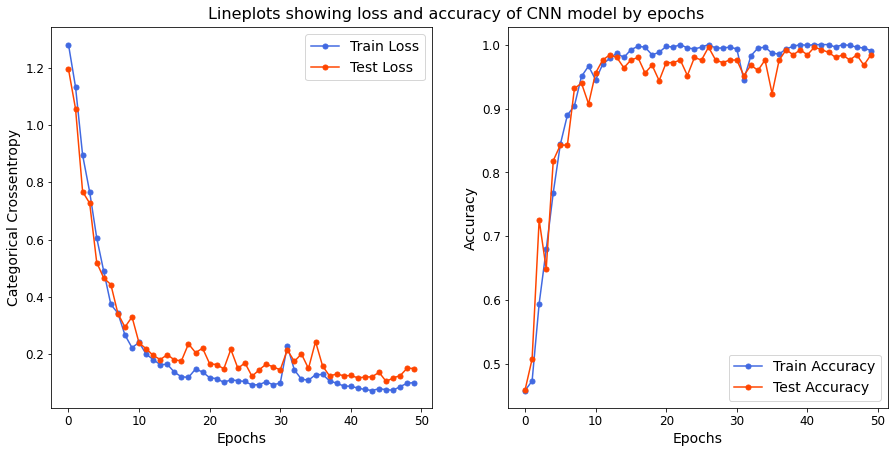

In [ ]:
# Plotting a line chart to visualize the loss and accuracy values by epochs.

fig, ax = plt.subplots(ncols=2, figsize=(15,7))

ax = ax.ravel()

ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color = 'orangered', marker='o', markersize=5)

ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)

ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)

ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)

ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)

ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)

fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of CNN model by epochs", fontsize=16)

#Importing essential libraries

In [ ]:
from keras.models import load_model
from PIL import Image
import numpy as np
import cv2

#the following are to do with this interactive notebook code

%matplotlib inline 
from matplotlib import pyplot as plt # this lets you draw inline pictures in the notebooks
import pylab # this allows you to control figure size 
pylab.rcParams['figure.figsize'] = (10.0, 8.0) # this controls figure size in the notebook

In [ ]:
# Labels on Age, Gender and Emotion to be predicted

age_ranges = ['1-2', '3-9', '10-20', '21-27', '28-45', '46-65', '66-116']
gender_ranges = ['male', 'female']
emotion_ranges= ['positive','negative','neutral']

### Loading Test Images

In [ ]:
#img_path = "/content/drive/MyDrive/test_input/images/priyanka_chopra.jpg"
#img_path = "/content/drive/MyDrive/test_input/images/kartik_aryan.jpg"
#img_path = "/content/drive/MyDrive/test_input/images/family.jpg"
img_path = "/content/drive/MyDrive/test_input/images/angryGirl2.jpg"

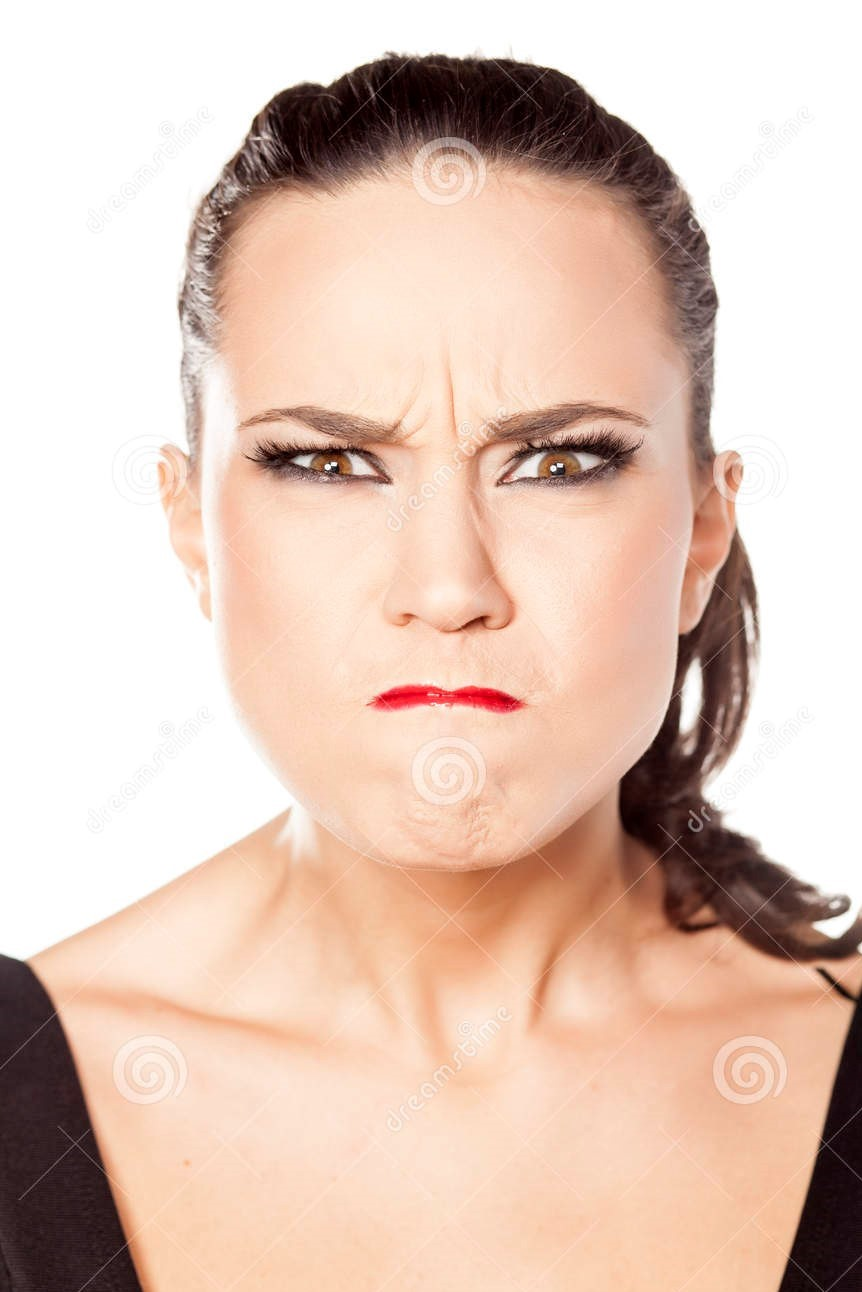

In [ ]:
from IPython.display import Image 
pil_img = Image(filename=img_path)
display(pil_img)

#Results on Age/Gender/Emotion

1: negative


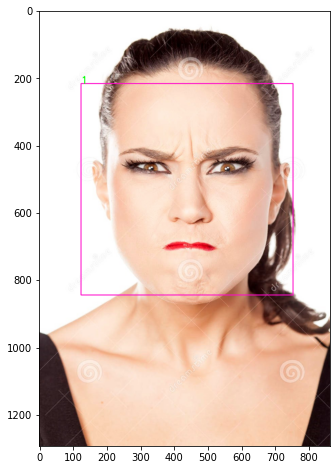

In [ ]:
test_image = cv2.imread(img_path)
gray = cv2.cvtColor(test_image,cv2.COLOR_BGR2GRAY)
face_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/test_input/cv2_cascade_classifier/haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(gray, 1.3, 5)

i = 0

for (x,y,w,h) in faces:
  i = i+1
  cv2.rectangle(test_image,(x,y),(x+w,y+h),(203,12,255),2)

  img_gray=gray[y:y+h,x:x+w]

  emotion_img = cv2.resize(img_gray, (48, 48), interpolation = cv2.INTER_AREA)
  emotion_image_array = np.array(emotion_img)
  emotion_input = np.expand_dims(emotion_image_array, axis=0)
  output_emotion= emotion_ranges[np.argmax(model.predict(emotion_input))]
  
  #gender_img = cv2.resize(img_gray, (100, 100), interpolation = cv2.INTER_AREA)
  #gender_image_array = np.array(gender_img)
  #gender_input = np.expand_dims(gender_image_array, axis=0)
  #output_gender=gender_ranges[np.argmax(gender_model.predict(gender_input))]

  #age_image=cv2.resize(img_gray, (200, 200), interpolation = cv2.INTER_AREA)
  #age_input = age_image.reshape(-1, 200, 200, 1)
  #output_age = age_ranges[np.argmax(age_model.predict(age_input))]


  output_str = str(i) + ": "+ output_emotion
  print(output_str)
  
  col = (0,255,0)

  cv2.putText(test_image, str(i),(x,y),cv2.FONT_HERSHEY_SIMPLEX,1,col,2)

plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))